In [23]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
print(torch.cuda.is_available())
use_cuda = True

True


In [ ]:
input_size = 28*28
classes = 10
epochs = 10
batch_size = 100
lr = 1e-2

In [ ]:
train_dataset = dsets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = dsets.MNIST(root='./data',train=False,transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self,no_of_weights):
    super(Autoencoder,self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.ReLU(True),
        nn.Linear(256, no_of_weights),
        nn.ReLU(True)
    )
    self.decoder = nn.Sequential(
        nn.Linear(no_of_weights, 256),
        nn.ReLU(True),
        nn.Linear(256, 28*28),
        nn.ReLU(True)
    )

  def forward(self, x):
    hl = self.encoder(x)
    out = self.decoder(hl)
    return hl,out

In [35]:
lr = 1e-2
no_of_weights = 64
ae = Autoencoder(no_of_weights)
if use_cuda and torch.cuda.is_available():
  ae.cuda()
  
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr)
  
losses = []
for epoch in range(epochs):
  running_loss,cnt = 0.0,0
  for i, (images, labels) in enumerate(train_loader):
    images = Variable(images.view(images.size(0),-1))
    labels = Variable(labels)
    
    if use_cuda and torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    optimizer.zero_grad()
    hl_out,outputs = ae(images)
    loss = criterion(outputs, images)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    cnt+=1
  epoch_loss = running_loss/cnt
  print('Epoch [%d/%d], Loss = %.5f'%(epoch+1,epochs,epoch_loss))
  losses.append(epoch_loss)

Epoch [1/10], Loss = 0.04509
Epoch [2/10], Loss = 0.03462
Epoch [3/10], Loss = 0.03346
Epoch [4/10], Loss = 0.03309
Epoch [5/10], Loss = 0.03286
Epoch [6/10], Loss = 0.03269
Epoch [7/10], Loss = 0.03247
Epoch [8/10], Loss = 0.03217
Epoch [9/10], Loss = 0.03209
Epoch [10/10], Loss = 0.03204


In [ ]:
ndata = len(train_dataset)
hSize = 64

iMat = torch.zeros((ndata,28*28))
rMat = torch.zeros((ndata,28*28))
featMat = torch.zeros((ndata,hSize))
labelMat = torch.zeros((ndata))
cntr=0

with torch.no_grad():
    for i,(images,labels) in enumerate(train_loader):

        images = images.view(-1, 28*28)
        images = images.cuda()
        
        hFeats,rImg = ae(images)
        
        iMat[cntr:cntr+batch_size,:] = images
        featMat[cntr:cntr+batch_size,:] = hFeats  
        labelMat[cntr:cntr+batch_size] = labels
        
        cntr+=batch_size
        
        if cntr>=ndata:
            break


In [ ]:
ndata_test = len(test_dataset)
hSize = 64
testFeatMat = torch.zeros((ndata,hSize))
testMat = torch.zeros((ndata_test,28*28))
testLabelMat = torch.zeros((ndata_test))
cntr=0
with torch.no_grad():
  for i,(images,labels) in enumerate(test_loader):
    images = images.view(-1, 28*28)
    images = images.cuda()
    
    hFeats,rImg = ae(images)
    testMat[cntr:cntr+batch_size,:] = images
    testFeatMat[cntr:cntr+batch_size,:] = hFeats
    testLabelMat[cntr:cntr+batch_size] = labels
    cntr+=batch_size    
    if cntr>=ndata_test:
        break

In [ ]:
alltrain_Features = iMat.numpy()[:10000,:]
htrain_Features = featMat.numpy()[:10000,:]
train_labels = labelMat.numpy()[:10000]
alltest_Features = testMat.numpy()[:1000,:]
htest_Features = testFeatMat.numpy()[:1000,:]
test_labels = testLabelMat.numpy()[:1000]

In [39]:
from sklearn.neural_network import MLPClassifier
clf1 = MLPClassifier(hidden_layer_sizes=(1000,1000),max_iter=200,learning_rate_init=0.0005)
clf1.fit(alltrain_Features,train_labels)
clf2 = MLPClassifier(hidden_layer_sizes=(1000,1000),max_iter=200,learning_rate_init=0.005)
clf2.fit(htrain_Features,train_labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000, 1000), learning_rate='constant',
              learning_rate_init=0.005, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

0.969
0.877


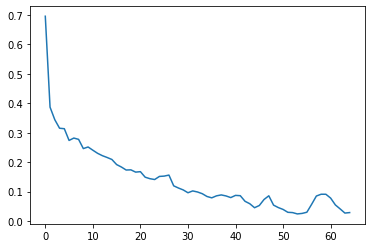

In [40]:
print(clf1.score(alltest_Features, test_labels))
print(clf2.score(htest_Features, test_labels))
plt.plot(clf2.loss_curve_)